In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Kaan/gas_turbin

Mounted at /content/drive
/content/drive/MyDrive/Kaan/gas_turbin


# **VERİ İNCELEME**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
data = scipy.io.loadmat('data/Gas_Turbine_Co_NoX_2015.mat')
X = data['feat']
y = data['lbl1']
X.shape[-1]

9

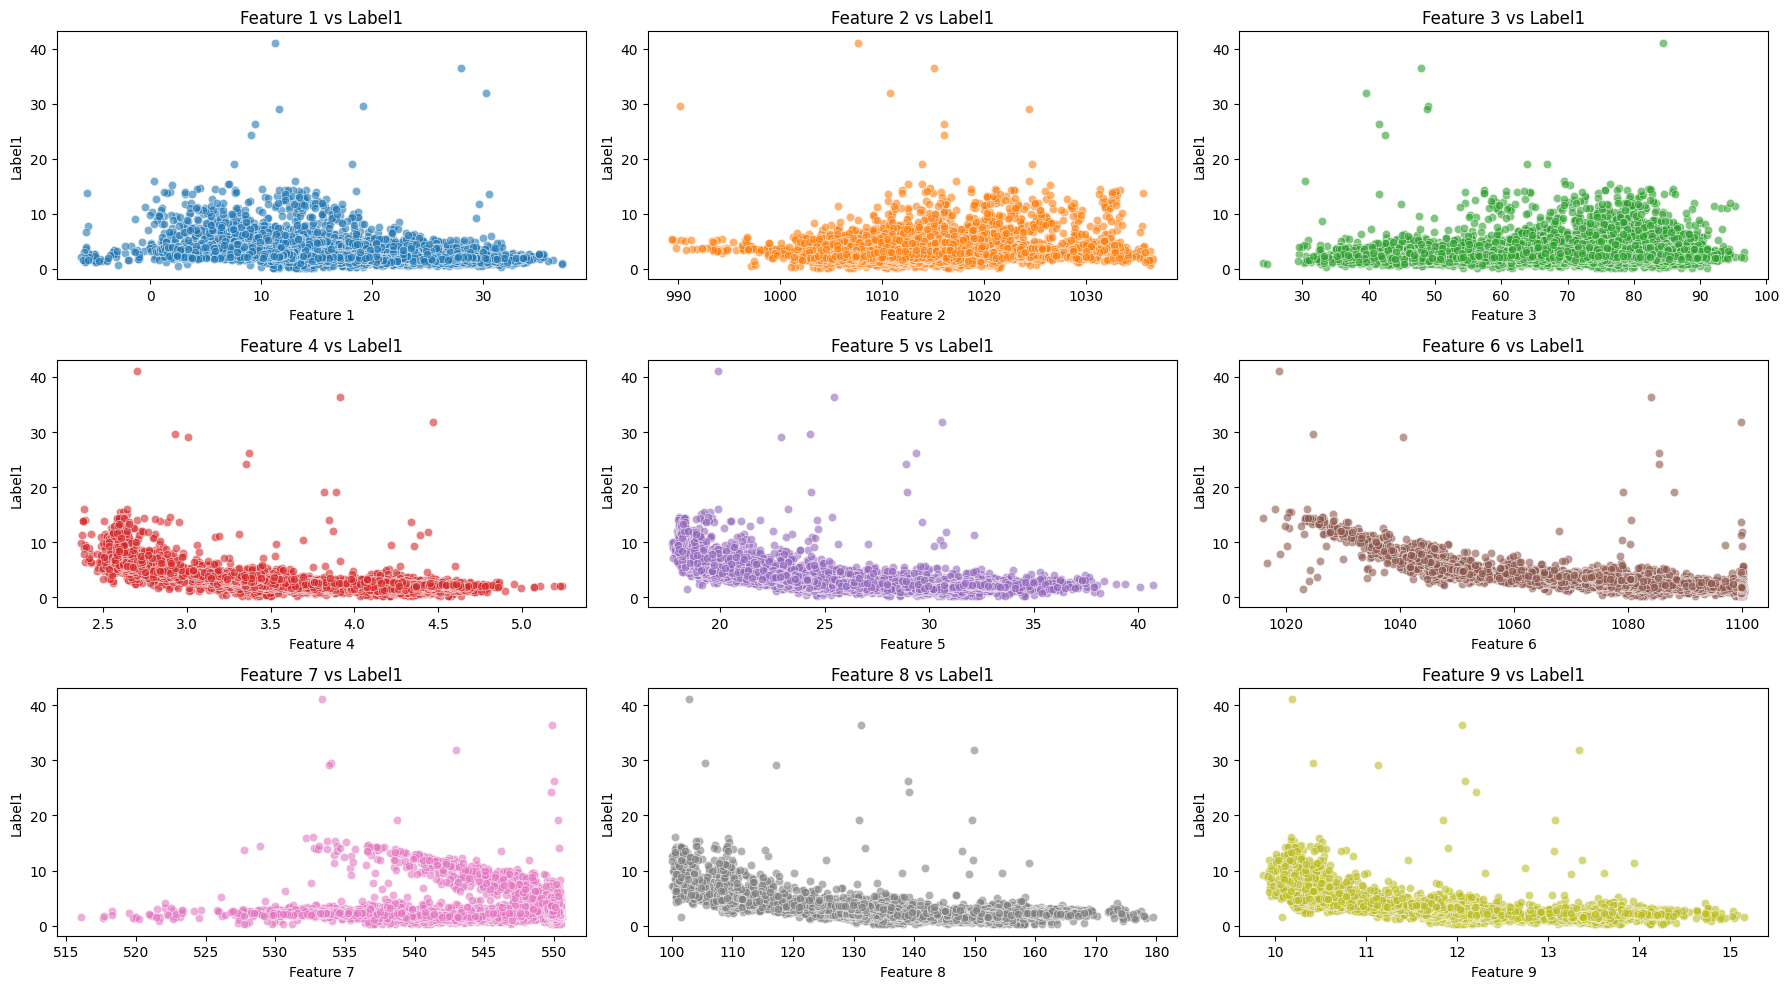

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot ayarları
plt.figure(figsize=(18, 10))

for i in range(X.shape[-1]):  # X.shape[-1] -> 9
    plt.subplot(3, 3, i+1)  # 3x3 grid düzeni
    sns.scatterplot(x=X[:, i], y=y.flatten(), alpha=0.6, color=f"C{i}")
    plt.title(f"Feature {i+1} vs Label1")
    plt.xlabel(f"Feature {i+1}")
    plt.ylabel("Label1")

plt.tight_layout()
plt.show()


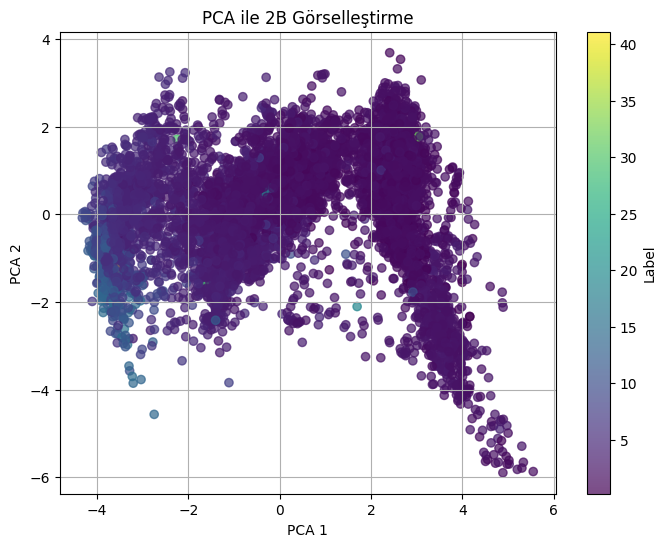

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA uygulama
pca = PCA(n_components=2)  # İlk 2 bileşeni alacağız
X_pca = pca.fit_transform(X_scaled)

# PCA sonuçlarını görselleştirme
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Label")
plt.title("PCA ile 2B Görselleştirme")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [ ]:
# PCA'yı tüm bileşenler için yeniden uygulama
pca_full = PCA(n_components=X_scaled.shape[1])
X_pca_full = pca_full.fit_transform(X_scaled)

# Tüm bileşenlerin açıkladığı varyans oranları
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Her bir bileşenin açıkladığı varyans oranları:")
for i, variance in enumerate(explained_variance, start=1):
    print(f"Bileşen {i}: {variance:.4f}")

print("\nToplam Kümülatif Varyans Oranı:")
for i, cumulative in enumerate(cumulative_variance, start=1):
    print(f"İlk {i} bileşen: {cumulative:.4f}")

Her bir bileşenin açıkladığı varyans oranları:
Bileşen 1: 0.5803
Bileşen 2: 0.2088
Bileşen 3: 0.0987
Bileşen 4: 0.0551
Bileşen 5: 0.0440
Bileşen 6: 0.0092
Bileşen 7: 0.0037
Bileşen 8: 0.0002
Bileşen 9: 0.0001

Toplam Kümülatif Varyans Oranı:
İlk 1 bileşen: 0.5803
İlk 2 bileşen: 0.7891
İlk 3 bileşen: 0.8879
İlk 4 bileşen: 0.9429
İlk 5 bileşen: 0.9869
İlk 6 bileşen: 0.9961
İlk 7 bileşen: 0.9998
İlk 8 bileşen: 0.9999
İlk 9 bileşen: 1.0000


# **MODEL EĞİTİMİ**

In [ ]:
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import scipy.io

# SMAPE hesaplama fonksiyonu
def smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    smape_value = 2 * np.mean(np.abs(y_true - y_pred) / denominator) * 100
    return smape_value

# Veriyi yükleme
data = scipy.io.loadmat('data/Gas_Turbine_Co_NoX_2015.mat')
X = data['feat']
y = data['lbl1'].flatten()  # Doğru hedef sütun kullanılmalı

# Veriyi normalize etme
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# K-Fold Ayarları
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Hiperparametre aralığı
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Model
xgb = XGBRegressor()

# SMAPE Skoru
smape_scorer = make_scorer(smape, greater_is_better=False)

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_absolute_error',  # Negatif MAE
    verbose=1,
    n_jobs=-1
)

# Grid Search Eğitimi
grid_search.fit(X, y)

# En iyi parametreler ve skor
best_params = grid_search.best_params_
best_score_mae = -grid_search.best_score_  # Sklearn negatif skor döndürür
print("En İyi Hiperparametreler:", best_params)
print(f"K-Fold Ortalama MAE: {best_score_mae:.4f}")

# En iyi model ile değerlendirme
best_model = grid_search.best_estimator_



Fitting 2 folds for each of 54 candidates, totalling 108 fits
En İyi Hiperparametreler: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
K-Fold Ortalama MAE: 0.4932


In [ ]:
# K-Fold değerlendirme metrikleri
mae_list, mse_list, smape_list = [], [], []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))
    smape_list.append(smape(y_test, y_pred))

# Ortalama değerlendirme metrikleri
mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_smape = np.mean(smape_list)

print(f"K-Fold Ortalama MAE: {mean_mae:.4f}")
print(f"K-Fold Ortalama MSE: {mean_mse:.4f}")
print(f"K-Fold Ortalama SMAPE: {mean_smape:.4f}")


K-Fold Ortalama MAE: 0.4932
K-Fold Ortalama MSE: 1.3035
K-Fold Ortalama SMAPE: 17.1886


**NORMALİZE VERİLER:**

In [ ]:
print(f"K-Fold Ortalama MAE: {mean_mae:.4f}")
print(f"K-Fold Ortalama MSE: {mean_mse:.4f}")
print(f"K-Fold Ortalama SMAPE: {mean_smape:.4f}")

K-Fold Ortalama MAE: 0.4932
K-Fold Ortalama MSE: 1.3035
K-Fold Ortalama SMAPE: 17.1886


# **MLP**

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import scipy.io

# SMAPE hesaplama fonksiyonu
def smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    smape_value = 2 * np.mean(np.abs(y_true - y_pred) / denominator) * 100
    return smape_value

# Veriyi yükleme
data = scipy.io.loadmat('data/Gas_Turbine_Co_NoX_2015.mat')
X = data['feat']
y = data['lbl1'].flatten()  # Doğru hedef sütun kullanılmalı

# Veriyi normalize etme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold Ayarları
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Metrikleri tutacak listeler
mae_list, mse_list, smape_list = [], [], []

# MLP modeli tanımlama fonksiyonu
def create_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(1)  # Çıkış katmanı (regresyon)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')  # MSE kaybı
    return model

In [ ]:
# K-Fold döngüsü
for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Modeli oluşturma ve eğitme
    model = create_mlp(X_train.shape[1])
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Tahmin
    y_pred = model.predict(X_test).flatten()

    # Metrikleri hesaplama
    mae_list.append(mean_absolute_error(y_test, y_pred))
    mse_list.append(mean_squared_error(y_test, y_pred))
    smape_list.append(smape(y_test, y_pred))

# Ortalama değerlendirme metrikleri
mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_smape = np.mean(smape_list)

print(f"K-Fold Ortalama MAE: {mean_mae:.4f}")
print(f"K-Fold Ortalama MSE: {mean_mse:.4f}")
print(f"K-Fold Ortalama SMAPE: {mean_smape:.4f}")

116/116 [==============================] - 0s 1ms/step
K-Fold Ortalama MAE: 0.4920
K-Fold Ortalama MSE: 1.3282
K-Fold Ortalama SMAPE: 17.1676


In [ ]:
import pandas as pd # Import pandas library
data = scipy.io.loadmat('data/Gas_Turbine_Co_NoX_2015.mat')
X = data['feat']
y = data['lbl1'].flatten()
pd.Series(y.astype(np.float32)).describe() # Convert y to pandas Series and then use describe

,0
count,7384.000000
mean,3.129985
std,2.234962
min,0.212800
25%,1.808175
50%,2.533400
75%,3.702550
max,41.097000


In [ ]:
data = scipy.io.loadmat('data/Gas_Turbine_Co_NoX_2015.mat')
X = data['feat']
y = data['lbl1']

print(X.shape)
print(y.shape)

(7384, 9)
(7384, 1)


# **SVM**

In [5]:
from sklearn.preprocessing import StandardScaler
import scipy.io
import numpy as np

# Veriyi yükleme
data = scipy.io.loadmat('data/Gas_Turbine_Co_NoX_2015.mat')
X = data['feat']
y = data['lbl1'].flatten()  # Doğru hedef sütun kullanılmalı

# X'in ortalaması (orijinal veri)
X_mean = X.mean(axis=0)  # Her sütunun ortalaması
print("Orijinal X ortalamaları (sütun bazında):", X_mean)

# Veriyi normalize etme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# X_scaled'in ortalaması (normalize edilmiş veri)
X_scaled_mean = X_scaled.mean(axis=0)  # Her sütunun ortalaması
print("Normalize edilmiş X_scaled ortalamaları (sütun bazında):", X_scaled_mean.round(8))


Orijinal X ortalamaları (sütun bazında): [  17.22525929 1014.50911024   68.64746411    3.59890906   26.1301487
 1078.97468852  546.64248375  133.99338028   12.09702474]
Normalize edilmiş X_scaled ortalamaları (sütun bazında): [ 0.  0.  0.  0.  0. -0.  0. -0. -0.]


In [2]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import scipy.io

# SMAPE hesaplama fonksiyonu
def smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    smape_value = 2 * np.mean(np.abs(y_true - y_pred) / denominator) * 100
    return smape_value

# Veriyi yükleme
data = scipy.io.loadmat('data/Gas_Turbine_Co_NoX_2015.mat')
X = data['feat']
y = data['lbl1'].flatten()  # Doğru hedef sütun kullanılmalı

# Veriyi normalize etme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold Ayarları
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# Denenecek kernel türleri
kernels = ['linear', 'poly', 'rbf']

# Tüm kernel türleri için metrikleri tutacak sözlük
results = {kernel: {'mae': [], 'mse': [], 'smape': []} for kernel in kernels}

# Kernel türlerine göre SVM modeli oluşturup K-Fold uygulama
for kernel in kernels:
    print(f"Kernel Türü: {kernel}")

    # Polinomial kernel için ek parametreler
    if kernel == 'poly':
        degree = 3  # Polinomial kernel için derece
    else:
        degree = 3  # Varsayılan polinomial derecesi

    # K-Fold döngüsü
    for train_idx, test_idx in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # SVM Modeli
        model = SVR(kernel=kernel, degree=degree) if kernel == 'poly' else SVR(kernel=kernel)
        model.fit(X_train, y_train)

        # Tahmin
        y_pred = model.predict(X_test)

        # Metrikleri hesaplama
        results[kernel]['mae'].append(mean_absolute_error(y_test, y_pred))
        results[kernel]['mse'].append(mean_squared_error(y_test, y_pred))
        results[kernel]['smape'].append(smape(y_test, y_pred))

    # Ortalama metrikleri hesaplama
    mean_mae = np.mean(results[kernel]['mae'])
    mean_mse = np.mean(results[kernel]['mse'])
    mean_smape = np.mean(results[kernel]['smape'])

    print(f"K-Fold Ortalama MAE: {mean_mae:.4f}")
    print(f"K-Fold Ortalama MSE: {mean_mse:.4f}")
    print(f"K-Fold Ortalama SMAPE: {mean_smape:.4f}")
    print("-" * 50)

# Sonuçları özet olarak yazdırma
print("Sonuçlar (K-Fold Ortalama):")
for kernel in kernels:
    print(f"{kernel.upper()} Kernel:")
    print(f"  MAE: {np.mean(results[kernel]['mae']):.4f}")
    print(f"  MSE: {np.mean(results[kernel]['mse']):.4f}")
    print(f"  SMAPE: {np.mean(results[kernel]['smape']):.4f}")
    print("-" * 30)


Kernel Türü: linear
K-Fold Ortalama MAE: 0.6925
K-Fold Ortalama MSE: 1.9758
K-Fold Ortalama SMAPE: 23.0513
--------------------------------------------------
Kernel Türü: poly
K-Fold Ortalama MAE: 0.5860
K-Fold Ortalama MSE: 1.4766
K-Fold Ortalama SMAPE: 20.9597
--------------------------------------------------
Kernel Türü: rbf
K-Fold Ortalama MAE: 0.4690
K-Fold Ortalama MSE: 1.3364
K-Fold Ortalama SMAPE: 16.2085
--------------------------------------------------
Sonuçlar (K-Fold Ortalama):
LINEAR Kernel:
  MAE: 0.6925
  MSE: 1.9758
  SMAPE: 23.0513
------------------------------
POLY Kernel:
  MAE: 0.5860
  MSE: 1.4766
  SMAPE: 20.9597
------------------------------
RBF Kernel:
  MAE: 0.4690
  MSE: 1.3364
  SMAPE: 16.2085
------------------------------


In [3]:
her= y_pred.mean(axis=0)
his= y.mean(axis=0)
print(his)
print(her)

3.1299855390032496
3.055661871909331
